In [3]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
import colorsys
import pingouin as pg

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']

stimrespdecodingfilename = 'D:\\stimdecoding_resp.csv'
stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
choicedecodingfilename = 'D:\\choicedecoding.csv'

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = '..\\Data\\Analysis_Cache'
ops_directory = '..\\Data\\Opsin_Cache'
beh_directory = '..\\Data\\Behavioor'

In [4]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

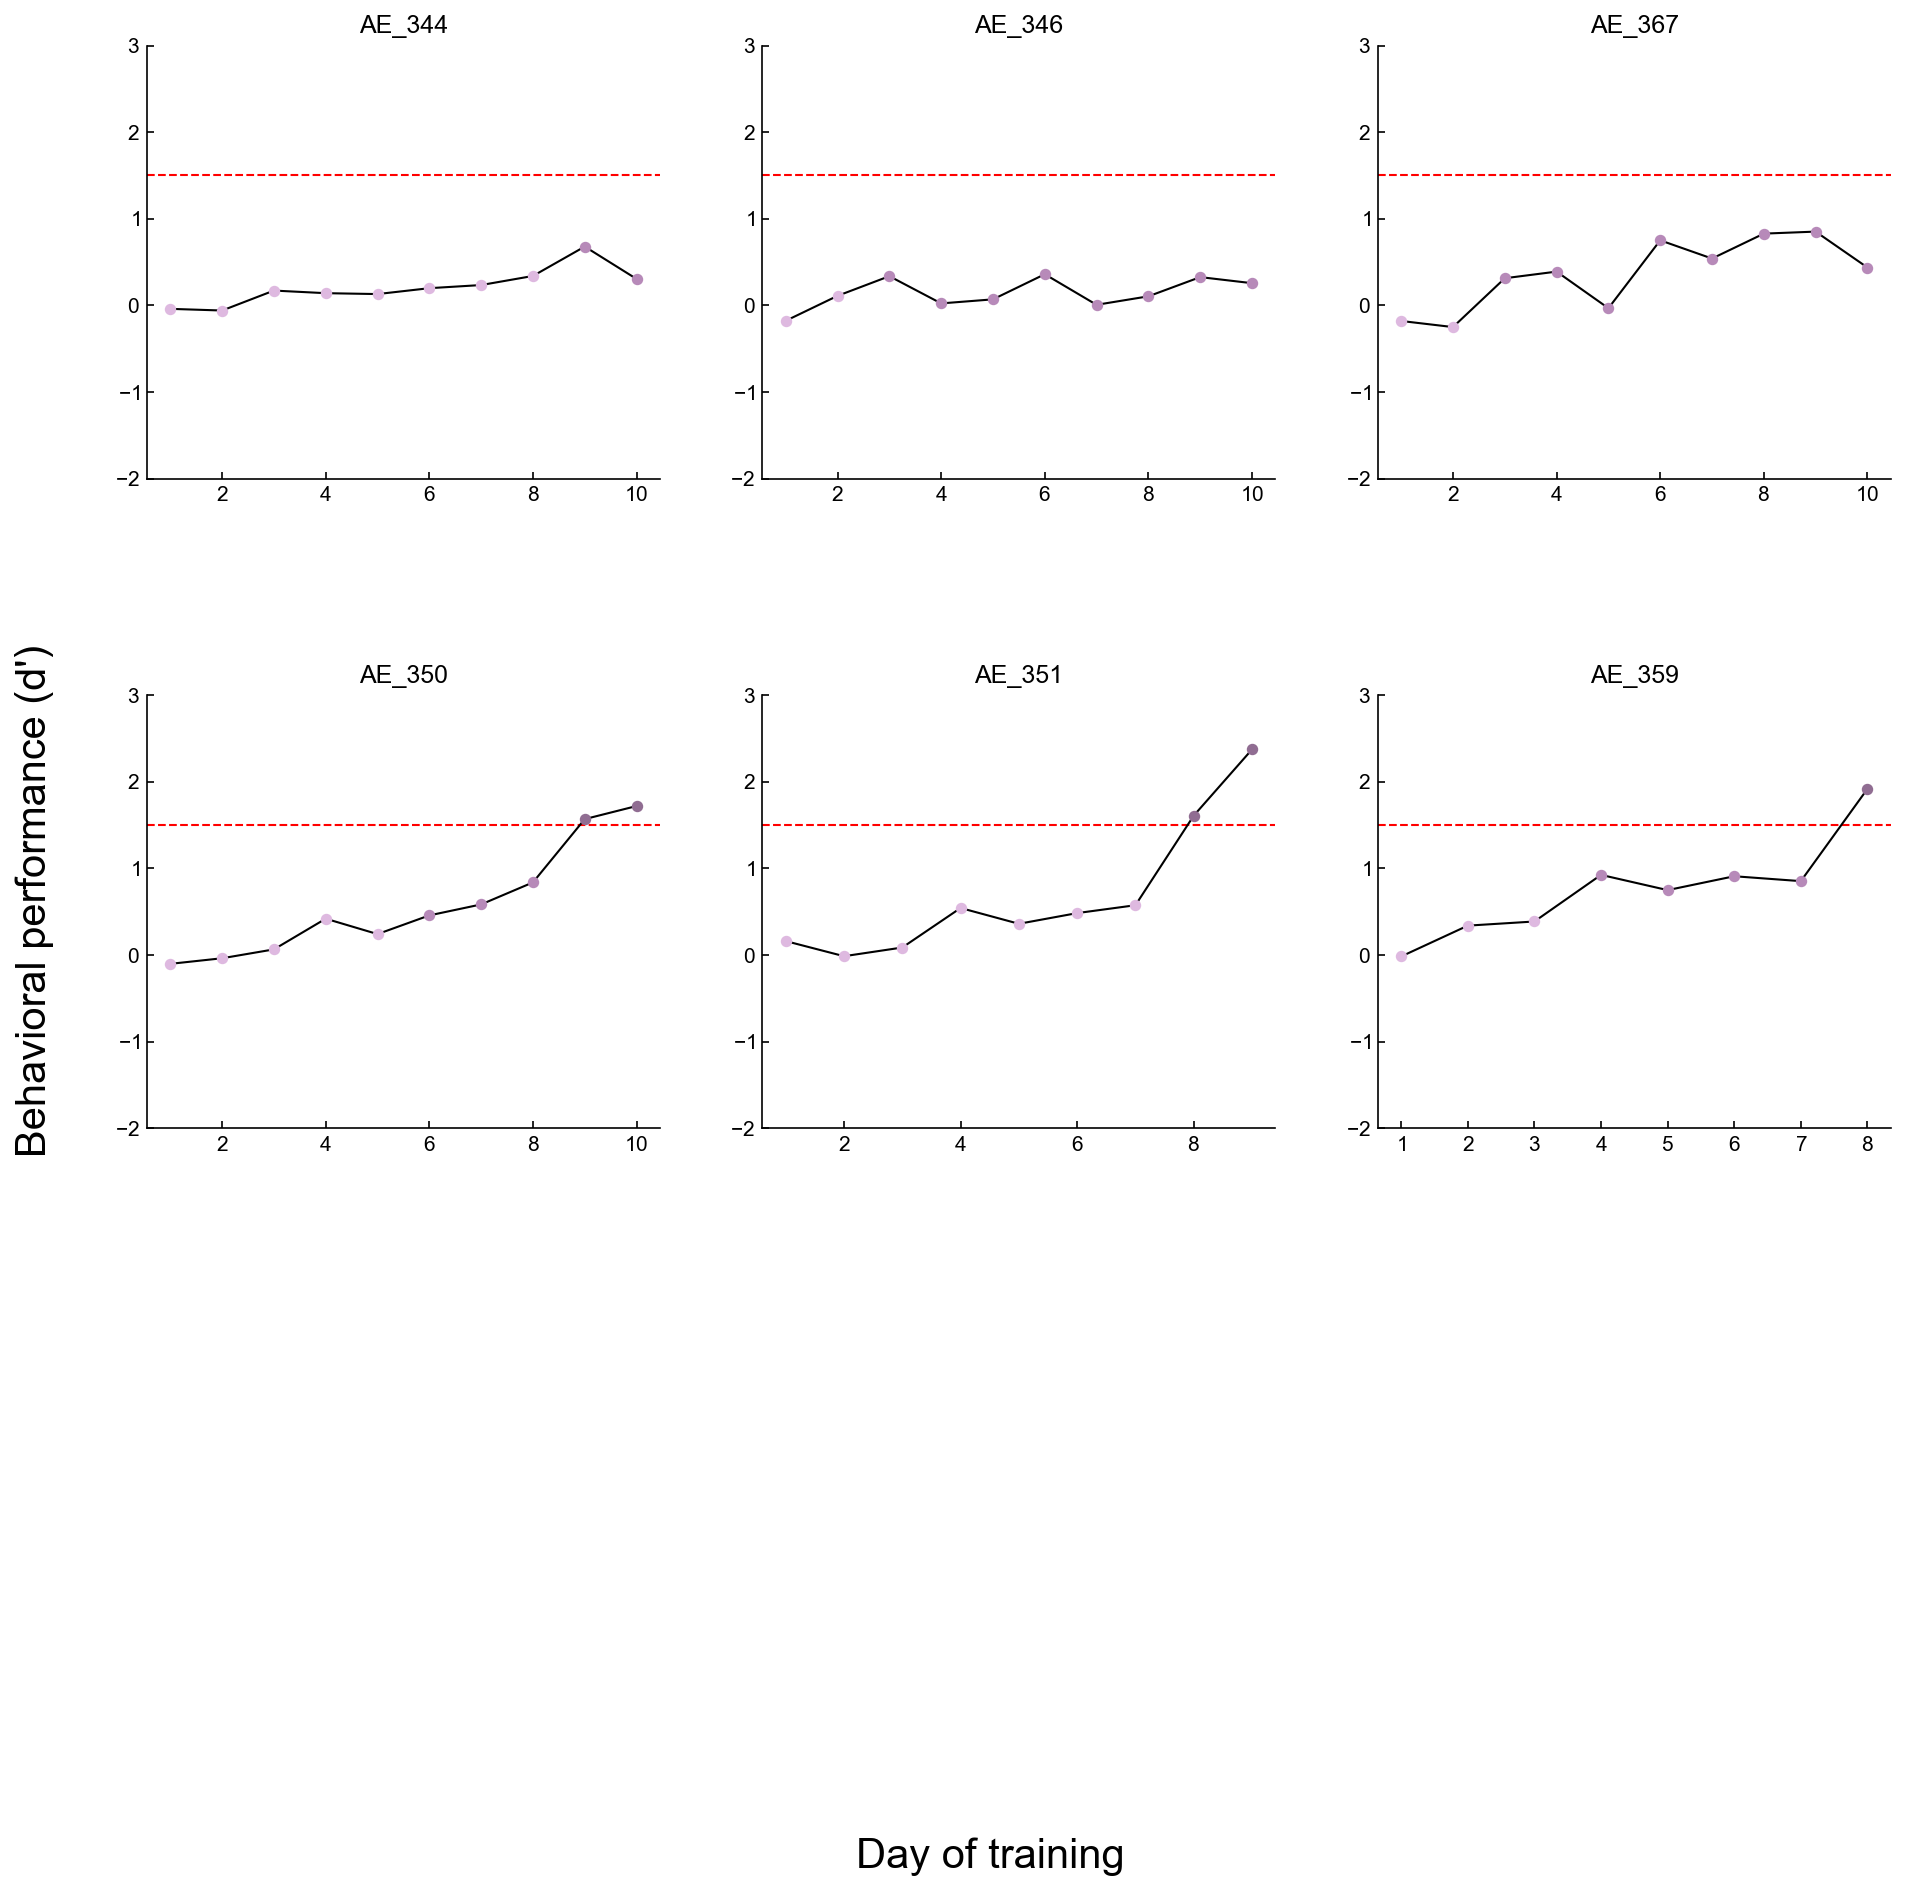

In [5]:
#animals = ['AE_267','AO_273','AO_274','AE_287']
animals = ['AE_344','AE_346','AE_367','AE_350','AE_351','AE_359']

learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)

In [6]:
def getTrialsPerDayPerAnimal(animalBehaviors,animal,days,expert_days):    
    reversal = np.Inf
    if hasattr(animalBehaviors[animal],'reversal'):
        reversal = animalBehaviors[animal].reversal
        
    #We will remove the duplicate reversal day because we will calculate both
    #pre and post reversal when we get there at once
    days = np.unique(days)
    
    trials_list_per_day = dict()
    
    for day in days:
        if not day in animalBehaviors[animal].sessions:
            continue
            
        outcomes = np.array(animalBehaviors[animal].sessions[day].outcomes)
        valid_trials = np.array(range(len(outcomes)))
        ########## Pre/Postreversal ##########
        if day != reversal:
            
            exceptionTrials = ilep.exceptionsForSpecificBehaviorDays(animal,day)
            if not exceptionTrials is None:
                valid_trials = exceptionTrials
            elif day in expert_days:
                valid_trials = ilep.getActiveTrials(outcomes)
        
        trials_list_per_day[day] = valid_trials
        
    return trials_list_per_day




trialsPerDay = dict()
for animal in animalBehaviors:
    try:
        days = [k for k in animalBehaviors[animal].sessions]

        learning_phases,_,_ = ilep.calculateLearningPhasesV2([animal],animalBehaviors,plot=False)
        expert_days = np.concatenate([learning_phases[animal].pre_expert_days,learning_phases[animal].post_expert_days,learning_phases[animal].second_expert_days])

        trials_list = getTrialsPerDayPerAnimal(animalBehaviors,animal,days,expert_days)

        trialsPerDay[animal] = trials_list
        
    except Exception as e:
        print(f"{animal} has exception {e}")
        if animal == 'BS_73':
            raise e
        trialsPerDay[animal] = None
pass

C:\Users\4thgr\OneDrive\Documents\TothSidleck2024\Notebooks\..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in scalar divide
  pc = (hit+creject)/(hit+miss+falarm+creject)
C:\Users\4thgr\OneDrive\Documents\TothSidleck2024\Notebooks\..\InsanallyLabEphysTools\behavior.py:359: RuntimeWarning: invalid value encountered in scalar divide
  pc = (hit+creject)/(hit+miss+falarm+creject)


[ 9 10 11 12 13]
[15 16 17 18 19 20 21 23 24 25]
there are 398 trials in AE_239 day 39
there are 116 trials in AE_239 day 20
PC is 0.7758620689655172 and DP is 1.59902324595228


In [9]:
trialsPerDay
with open('..\\Data\\trialsToUsePerDayWithPreOpto', 'wb') as f:
        pickle.dump(trialsPerDay, f, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
with open('..\\Data\\trialsToUsePerDayWithPreOpto', 'rb') as f:
        trialsPerDayLoaded = pickle.load(f)

In [12]:
trialsPerDayLoaded

{'BS_51': {1: array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
          13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
          26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
          39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
          52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
          65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
          78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
          91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
         104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
         117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
         130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
         143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
         156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
         169, 170, 171, 17